# Download Dataset

In [1]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/image-search/sample_submission.csv
/kaggle/input/image-search/zeroshot_clip.py
/kaggle/input/image-search/queries/queries/20.jpg
/kaggle/input/image-search/queries/queries/6.jpg
/kaggle/input/image-search/queries/queries/5.jpg
/kaggle/input/image-search/queries/queries/8.jpg
/kaggle/input/image-search/queries/queries/10.jpg
/kaggle/input/image-search/queries/queries/0.jpg
/kaggle/input/image-search/queries/queries/9.jpg
/kaggle/input/image-search/queries/queries/1.jpg
/kaggle/input/image-search/queries/queries/16.jpg
/kaggle/input/image-search/queries/queries/7.jpg
/kaggle/input/image-search/queries/queries/13.jpg
/kaggle/input/image-search/queries/queries/17.jpg
/kaggle/input/image-search/queries/queries/15.jpg
/kaggle/input/image-search/queries/queries/12.jpg
/kaggle/input/image-search/queries/queries/11.jpg
/kaggle/input/image-search/queries/queries/21.jpg
/kaggle/input/image-search/queries/queries/4.jpg
/kaggle/input/image-search/queries/queries/3.jpg
/kaggle/input/im

# Install Clip

In [2]:
!pip -q install datasets open_clip_torch
!pip -q install git+https://github.com/facebookresearch/segment-anything.git
!pip -q install opencv-python pycocotools matplotlib onnxruntime onnx

# Import Libary

In [3]:
from transformers import AutoModel, CLIPProcessor
from PIL import Image, ImageEnhance
import os
import pandas as pd
from PIL import Image
import torch

# Image Search

In [4]:
src_dir = '/kaggle/input/image-search/test/images'
query_dir = '/kaggle/input/image-search/queries/queries'
submission = pd.read_csv('/kaggle/input/image-search/sample_submission.csv')
submission['dot_class'] = 22
submission['cosine_class'] = 22

model = AutoModel.from_pretrained('laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K').cuda().eval()
processor = CLIPProcessor.from_pretrained('laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K')

config.json:   0%|          | 0.00/4.41k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
2024-02-04 09:35:05.147808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 09:35:05.147958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 09:35:05.278782: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one h

preprocessor_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

In [5]:
def preprocessing(enhanced_image):
    sharpness_factor = 5
    contrast_factor = 2
    enhanced_image = enhanced_image.convert('L')
    enhanced_image = ImageEnhance.Contrast(enhanced_image).enhance(contrast_factor)
    enhanced_image = ImageEnhance.Sharpness(enhanced_image).enhance(sharpness_factor)
    return enhanced_image

In [6]:
with torch.no_grad():
        query_images = []
        query_classes = []
        for file in os.listdir(query_dir):
            inputs = processor(images=[Image.open(os.path.join(query_dir, file)).convert('L')], return_tensors='pt').to('cuda')
            outputs = model.get_image_features(inputs.pixel_values).cuda()
            outputs = outputs / outputs.norm(p=2, dim=-1, keepdim=True)
            query_images.append(outputs)
            query_classes.append(int(file[:-4]))
        query_images = torch.cat(query_images)
        for idx, row in submission.iterrows():
            if not pd.isna(row['class']):
                continue
            inputs = processor(images=[preprocessing(Image.open(os.path.join(src_dir, row['img_file'])))], return_tensors='pt').to('cuda')
            outputs = model.get_image_features(inputs.pixel_values).cuda()
            outputs = outputs / outputs.norm(p=2, dim=-1, keepdim=True)
            values = outputs @ query_images.T
            if values.softmax(1).max() > .065:
                submission.at[idx, 'dot_class'] = query_classes[values.argmax().tolist()]
            cosine = torch.cosine_similarity(outputs, query_images)
            if cosine.max() > 0.7:
                submission.at[idx, 'cosine_class'] = query_classes[cosine.argmax().tolist()]
        sub = submission[['img_file',]]
        sub['class'] = submission['cosine_class']
        sub.to_csv('laion_cs_t.0.7_sh-5_ct-2_s.csv', index=False)
        sub['class'] = submission['dot_class']
        sub.to_csv('laion_dot_t.0.065_sh-5_ct-2_s.csv', index=False)

/tmp/ipykernel_26/173200574.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['cosine_class']
/tmp/ipykernel_26/173200574.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['dot_class']


In [7]:
cosine = pd.read_csv("/kaggle/working/laion_cs_t.0.7_sh-5_ct-2_s.csv")
dotpro = pd.read_csv("/kaggle/working/laion_dot_t.0.065_sh-5_ct-2_s.csv")
df = cosine.groupby('class').count()[['img_file']]
df['img_file_dot'] = dotpro.groupby('class').count()['img_file']
df

,img_file,img_file_dot
class,,
0,5,4
1,43,39
2,2,2
3,114,103
4,4,4
5,65,45
6,17,17
7,2,2
8,1,1


In [8]:
import matplotlib.pyplot as plt

def read_and_display_images(dataset):
    rows, cols = 4, 5
    fig = plt.figure(figsize=(12, 8))
    c = 0
    for i in range(0, 1000, 50):
        ax = fig.add_subplot(rows, cols, c + 1)
        image_path = dataset["img_file"][i]
        label = dataset["class"][i]
        image = Image.open("/kaggle/input/image-search/test/images/" + image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"{label}")
        c += 1
    plt.show()

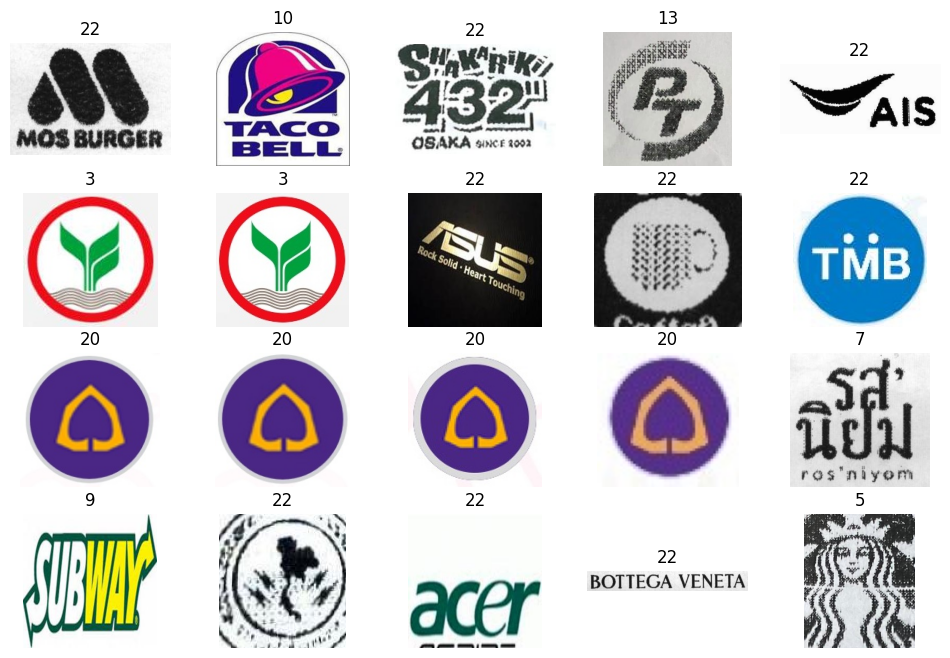

In [9]:
read_and_display_images(cosine)

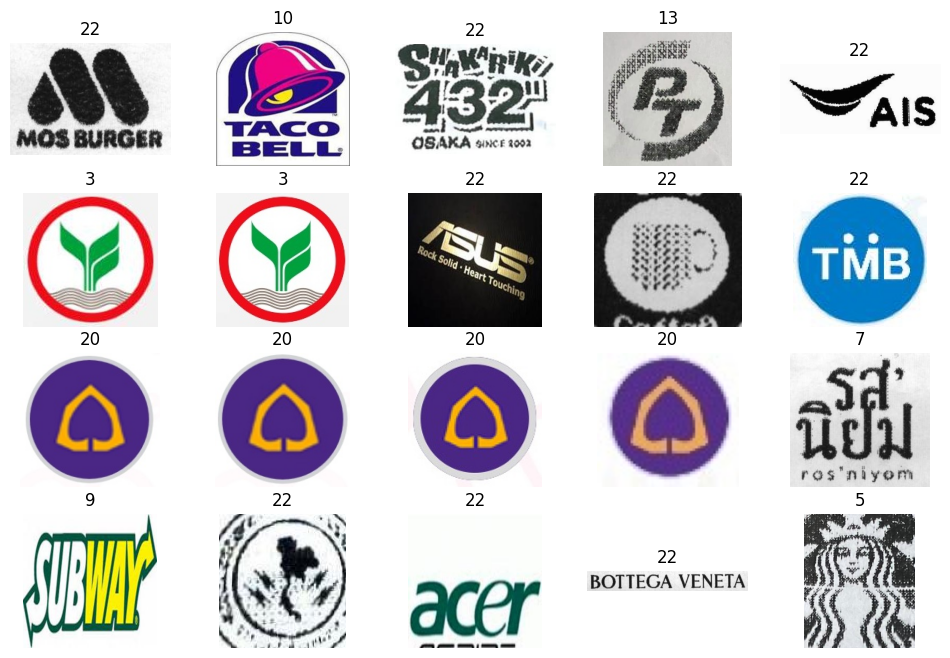

In [10]:
read_and_display_images(dotpro)